In this notebook, I build a complete pipeline and apply it to images in the test_images folder.

Please feel free to run this on any other images, I have set it to run on the first image only.

Here is a summary of the pipeline:

1. Read in the image
2. Read in the distortion martix saved by the previous notebook (01_Distortion)
3. Undistort image
4. Apply perspective transform to get birds eye view and eliminate unnecessary parts of the image
5. Apply thresholding to the warped image. I specifically apply five different transforms & threshold them:
    * Tr1: The Red channel from the RGB image
    * Tr2: "Value" from the HSV space
    * Tr3: "Saturation" from the HLS space
    * Tr4: Sobel gradient in the x direction
    * Tr5: Color mask, looking for yellow.
6. Calculate the norm of each binary threshold and pick only the suitable ones. I chose thresholds of 50 and 170 below. So images below 50 are mostly blank and images above 170 are mostly scattered noise. 
7. Combine all the picked thresholds using an OR gate
8. Search for points that indicate lanes in the thresholded image. I take 10 rows of pixels and search them at a time. I search the left half of the image for the left lane line and the right half of the image for the right lane line.
9. Fit a curve to the detected lane lines. I fit a line and a parabola and blend them. I found that a parabola can overfit the points when there are only a few points. 
10. Create a polygon from the curve fits, fill it with green color, unwarp it to the correct perspective and overlay it on the original image.
11. Calculate the position of the polygon wrt to the image and report that as the "Position". Also calculate the average radius of curvature of the left and right fits and report that as "Curvature". Note that the unit of the radius of curvature is /px ... this can be converted into /m if the px to m scale of the camera is known.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  
import glob
import pickle
from moviepy.editor import VideoFileClip



In [2]:
# Read in the distortion coefficients
objects = []
with (open("dist_pickle.p", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
            dist_pickle = {}

dist = objects[0]['dist']
mtx = objects[0]['mtx']

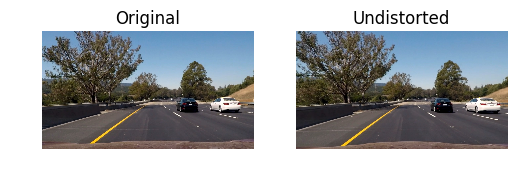

In [3]:
#Apply the distortion correction to the raw image and plot them side by side
img = mpimg.imread('test_images/test6.jpg')
img_undist = cv2.undistort(img, mtx, dist, None, mtx)
xs = img_undist.shape[1]
ys = img_undist.shape[0]

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_undist)
plt.title('Undistorted')
plt.axis('off')
  
plt.show()

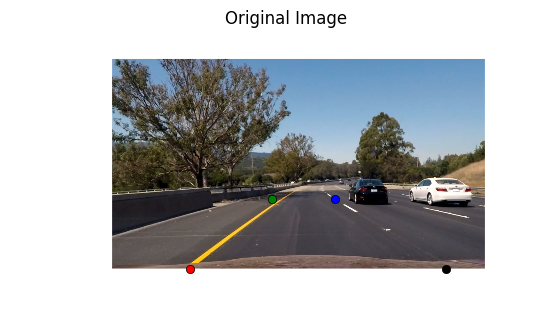

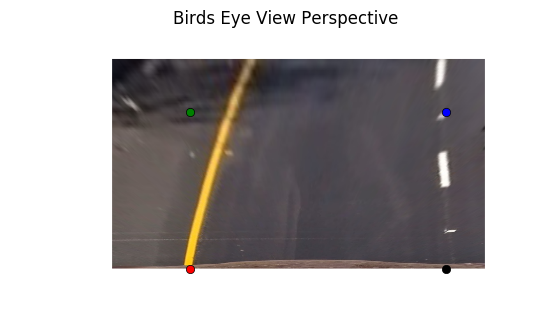

In [4]:
#Apply a perspective transform to rectify binary image ("birds-eye view").
plt.imshow(img_undist)
plt.plot(270,719,'ro')
plt.plot(550,480,'go')
plt.plot(770,480,'bo')
plt.plot(1150,719,'ko')
plt.title('Original Image')
plt.axis('off')
plt.show()

src = np.float32([[270,719],[550,480],[770,480],[1150,719]])
dst = np.float32([[270,719],[270,180],[1150,180],[1150,719]])

M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img_undist, M, (xs,ys), flags=cv2.INTER_LINEAR)
plt.imshow(warped)
plt.plot(270,719,'ro')
plt.plot(270,180,'go')
plt.plot(1150,180,'bo')
plt.plot(1150,719,'ko')
plt.title('Birds Eye View Perspective')
plt.axis('off')
plt.show()



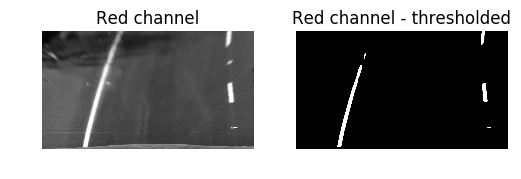

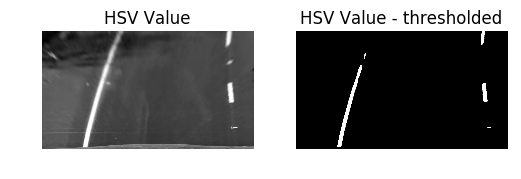

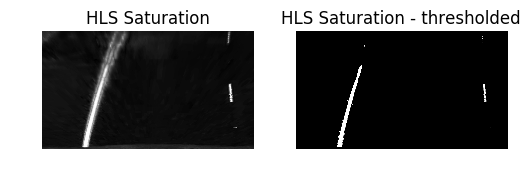

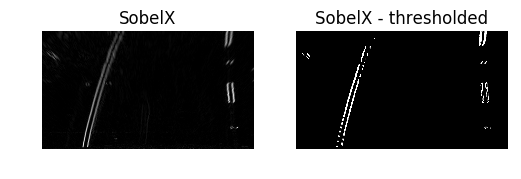

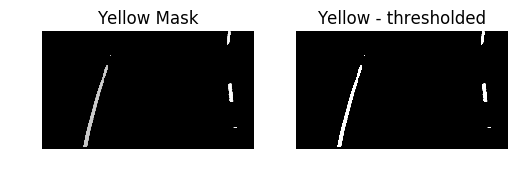

In [5]:
# Now look at various transform and thresholding
# Try 1 - red
try1 = warped[:,:,0]
try1_binary = np.zeros_like(try1)
try1_binary[(try1 >= 215) & (try1 <= 255)] = 1
plt.subplot(1, 2, 1)
plt.imshow(try1,cmap='gray')
plt.title('Red channel')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(try1_binary,cmap='gray')
plt.title('Red channel - thresholded')
plt.axis('off')
plt.show()

# Try 2 - HSV Value (very similar to Red)
try2 = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)
try2 = try2[:,:,2]
try2_binary = np.zeros_like(try2)
try2_binary[(try2 >= 215) & (try2 <= 255)] = 1
plt.subplot(1, 2, 1)
plt.imshow(try2,cmap='gray')
plt.title('HSV Value')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(try2_binary,cmap='gray')
plt.title('HSV Value - thresholded')
plt.axis('off')
plt.show()

# Try 3 - Saturation
try3 = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
try3 = try3[:,:,2]
try3_binary = np.zeros_like(try3)
try3_binary[(try3 >= 170) & (try3 <= 255)] = 1
plt.subplot(1, 2, 1)
plt.imshow(try3,cmap='gray')
plt.title('HLS Saturation')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(try3_binary,cmap='gray')
plt.title('HLS Saturation - thresholded')
plt.axis('off')
plt.show()

# Try 4 - Sobelx
try4 = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
try4 = np.absolute(cv2.Sobel(try4, cv2.CV_64F, 1, 0, ksize=17))
try4 = np.uint8(255*try4/np.max(try4))
try4_binary = np.zeros_like(try4)
try4_binary[(try4 >= 70) & (try4 <= 160)] = 1
plt.subplot(1, 2, 1)
plt.imshow(try4,cmap='gray')
plt.title('SobelX')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(try4_binary,cmap='gray')
plt.title('SobelX - thresholded')
plt.axis('off')
plt.show()

# Try -5 Color mask, looking for yellow
lower = np.array([220, 0, 0], dtype = "uint8")
upper = np.array([255, 255, 255], dtype = "uint8")
mask = cv2.inRange(warped, lower, upper)
try5 = cv2.bitwise_and(warped, warped, mask = mask)
try5 = cv2.cvtColor(try5, cv2.COLOR_RGB2GRAY)
try5_binary = np.zeros_like(try5)
try5_binary[(try5 > 0)] = 1
plt.subplot(1, 2, 1)
plt.imshow(try5,cmap='gray')
plt.title('Yellow Mask')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(try5_binary,cmap='gray')
plt.title('Yellow - thresholded')
plt.axis('off')
plt.show()

In [6]:
# Decide which thresholds to use.
# If the norm is under 175 use it, or else it's too noisy, then throw it away
print(np.linalg.norm(try1_binary))
print(np.linalg.norm(try2_binary))
print(np.linalg.norm(try3_binary))
print(np.linalg.norm(try4_binary))
print(np.linalg.norm(try5_binary))

noise_th1 = 50
noise_th2 = 170

if ((np.linalg.norm(try1_binary)<noise_th1)|(np.linalg.norm(try1_binary)>noise_th2)):
    try1_binary[:,:] = 0
if ((np.linalg.norm(try2_binary)<noise_th1)|(np.linalg.norm(try2_binary)>noise_th2)):
    try2_binary[:,:] = 0
if ((np.linalg.norm(try3_binary)<noise_th1)|(np.linalg.norm(try3_binary)>noise_th2)):
    try3_binary[:,:] = 0
if ((np.linalg.norm(try4_binary)<noise_th1)|(np.linalg.norm(try4_binary)>noise_th2)):
    try4_binary[:,:] = 0
if ((np.linalg.norm(try5_binary)<noise_th1)|(np.linalg.norm(try5_binary)>noise_th2)):
    try5_binary[:,:] = 0

sxbinary = np.zeros_like(try1_binary)
sxbinary[(try1_binary>0)|(try2_binary>0)|(try3_binary>0)|(try4_binary>0)|(try5_binary>0)] = 1

125.89281155
125.89281155
111.0
120.270528393
122.049170419


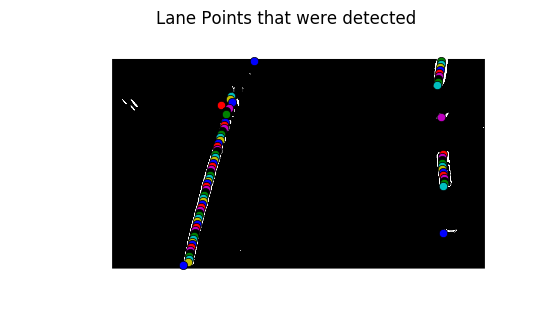

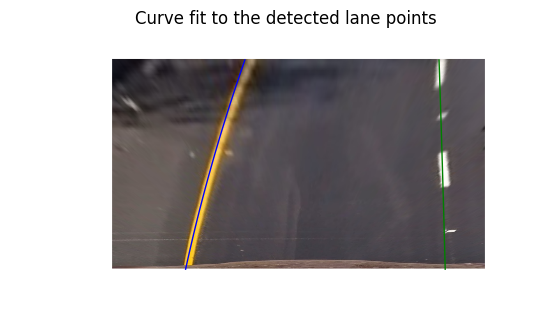

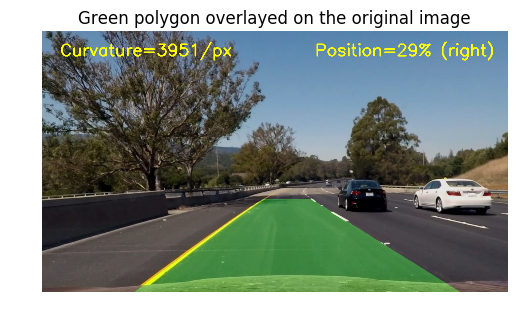

In [7]:
#Detect lane pixels and fit to find lane boundary.
#Determine curvature of the lane and vehicle position with respect to center.

# Start off a grid spaced every 10 pixels
ystarts = np.mgrid[0:ys:10]

plt.imshow(sxbinary, cmap='gray')
al1=np.zeros_like(ystarts)
al2=np.zeros_like(ystarts)

# Look for 9 out of ten filled pixels
threshold = 9

for j,i in enumerate(ystarts):
    # Sum up the ten rows
    a = np.sum(sxbinary[i:i+10,:],axis=0)
    az = np.zeros_like(a)
    # Look for at least 9 filled rows
    az[a > threshold]=1    
    
    # Get all the columns that pass the threshold, and find the average position
    # Search the *left* half of the image only
    a1=np.mean(np.nonzero(az[0:xs/2])).astype(int)
    if (a1 < 0):
        a1 = np.nan # Take care of columns that return no match
        al1[j]=-1   
    else:
        al1[j]=a1    
    
    # Get all the columns that pass the threshold, and find the average position
    # Search the *right* half of the image only
    a2=(np.mean(np.nonzero(az[xs/2:]))+(xs/2)).astype(int)
    if (a2 < 0):
        a2 = np.nan
        al2[j]=-1
    else:
        al2[j]=a2    
    plt.plot(a1,i+5,'o')
    plt.plot(a2,i+5,'o')
    
plt.title('Lane Points that were detected')
plt.axis('off')
plt.show()

plt.imshow(warped)


ystarts = np.append(ystarts,[ys]) # Add in the end of the image
lin_wt = 0.25

ystarts1 = ystarts
ystarts1 = ystarts1[al1>0] # Get only the valid ys
al1 = al1[al1>0]
zzr1 = np.polyfit(ystarts1,al1,1) # Fit line
zzr2 = np.polyfit(ystarts1,al1,2) # Fit parabola
xstarts1 = np.zeros_like(ystarts) # Evaluate for all ys, not just the valid ones
xstarts1 = np.polyval(zzr1,ystarts)*lin_wt+np.polyval(zzr2,ystarts)*(1-lin_wt) # Average the line and parabolar fits

plt.plot(xstarts1,ystarts)

ystarts2 = ystarts
ystarts2 = ystarts2[al2>0]
al2 = al2[al2>0]
zzr1 = np.polyfit(ystarts2,al2,1) # Fit line
zzr2 = np.polyfit(ystarts2,al2,2) # Fit parabola
xstarts2 = np.zeros_like(ystarts)

xstarts2 = np.polyval(zzr1,ystarts)*lin_wt+np.polyval(zzr2,ystarts)*(1-lin_wt) # Average the line and parabolar fits

plt.plot(xstarts2,ystarts)
plt.title('Curve fit to the detected lane points')
plt.axis('off')
plt.show()

pts = np.stack((np.append(xstarts1,xstarts2[::-1]),np.append(ystarts,ystarts[::-1])),axis=-1)
pts = pts.astype(int)
black_warped = np.zeros_like(warped)
black_warped_overlayed = cv2.fillConvexPoly(black_warped, pts,[0,255,0])
black_unwarped_overlayed = cv2.warpPerspective(black_warped_overlayed, M_inv, (xs,ys), flags=cv2.INTER_LINEAR)
final_overlay = cv2.addWeighted(img_undist, 0.9, black_unwarped_overlayed, 0.3, 0)

first_der1 = np.mean(np.diff(xstarts1,1))/(ystarts[1]-ystarts[0])
second_der1 = np.mean(np.diff(xstarts1,2))/((ystarts[1]-ystarts[0])^2)
curv1 = np.absolute(((1.0+first_der1*first_der1)**1.5)/second_der1)

first_der2 = np.mean(np.diff(xstarts2,1))/(ystarts[1]-ystarts[0])
second_der2 = np.mean(np.diff(xstarts2,2))/((ystarts[1]-ystarts[0])^2)
curv2 = np.absolute(((1.0+first_der2*first_der2)**1.5)/second_der2)

curv = (curv1+curv2)/2
str_curv = 'Curvature='+str(curv.astype(int))+'/px'
final_overlay = cv2.putText(final_overlay, str_curv,(50,70),cv2.FONT_HERSHEY_SIMPLEX,1.5,[255,255,0],3)

lane_size = xstarts2[1]-xstarts1[-1]
lane_center = (xstarts1[-1]+xstarts2[-1])/2
cam_size = xs
cam_center = xs/2
lane_pos = (lane_center-cam_center)/(cam_center-(lane_size/2))*100
if lane_pos > 0:
    str_pos = 'Position='+str(lane_pos.astype(int))+'% (right)'
else:
    str_pos = 'Position='+str(lane_pos.astype(int))+'% (left)'
        
final_overlay = cv2.putText(final_overlay, str_pos,(750,70),cv2.FONT_HERSHEY_SIMPLEX,1.5,[255,255,0],3)


plt.imshow(final_overlay)
plt.title('Green polygon overlayed on the original image')
plt.axis('off')
plt.show()

Here is what I mean by left & right position:

If the center of the camera image matches with the center of the lane, the position value reads 0%

So in this case, the camera is exactly centered with the lane lines
![Center, position = 0%](http://i.imgur.com/iwukbaw.png)

In this case, the camera frame is on the extreme right of the lane line, this corresponds to Position = 100% Right 
![Center, position = 0%](http://i.imgur.com/oWXjHFy.png)

In this case, the camera frame is on the extreme left of the lane line, this corresponds to Position = 100% Left 
![Center, position = 0%](http://i.imgur.com/buWlsHT.png)
